# Milestone 2 - Hypothesis Simulation 

## Author - Logan Downing
Datasci 410  
May 8, 2018  
v.1.0



## Instructions
Use the <a href="https://archive.ics.uci.edu/ml/datasets/Automobile">automotive data set</a> to perform the following:

1. Identify a likely distribution for price and several other features.
2. Compute basic summary statistics by both classical, bootstrap and Bayesian methods
3. Compute confidence intervals for the above summary statistics by classical, bootstrap and  Bayesian methods
4. Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are significant:
            Classical tests
            Tukey’s Honest Significant Differences (HSD)
            Bootstrap methods
            Bayesian model


### Note
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [1]:
# dataset from distribution
#fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"
fileName = 'Automobile.csv'

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy.random as random
import scipy
import scipy.stats as ss

# 1. Import data, examine features, clean values
Here we read in the data, look at the features, drop any uninteresting features, find records with missing values, and impute whatever is missing.

In [3]:
# import data. replace "?" marks with NaN
df = pd.read_csv(fileName,na_values="?")

# omit records without prices, those will not be interesting
# for this assignment. (drops 4 records)
df = df[df.price.notnull()]

In [4]:
df.head()

symboling  normalized-losses         make fuel-type aspiration  \
0          3                NaN  alfa-romero       gas        std   
1          3                NaN  alfa-romero       gas        std   
2          1                NaN  alfa-romero       gas        std   
3          2              164.0         audi       gas        std   
4          2              164.0         audi       gas        std   

  num-of-doors   body-style drive-wheels engine-location  wheel-base   ...     \
0          two  convertible          rwd           front        88.6   ...      
1          two  convertible          rwd           front        88.6   ...      
2          two    hatchback          rwd           front        94.5   ...      
3         four        sedan          fwd           front        99.8   ...      
4         four        sedan          4wd           front        99.4   ...      

   engine-size  fuel-system  bore  stroke compression-ratio horsepower  \
0          130         mpfi  3.47    2.68               9.0      111.0   
1          130         mpfi  3.47    2.68               9.0      111.0   
2          152         mpfi  2.68    3.47               9.0      154.0   
3          109         mpfi  3.19    3.40              10.0      102.0   
4          136         mpfi  3.19    3.40               8.0      115.0   

   peak-rpm city-mpg  highway-mpg    price  
0    5000.0       21           27  13495.0  
1    5000.0       21           27  16500.0  
2    5000.0       19           26  16500.0  
3    5500.0       24           30  13950.0  
4    5500.0       18           22  17450.0  

[5 rows x 26 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 204
Data columns (total 26 columns):
symboling            201 non-null int64
normalized-losses    164 non-null float64
make                 201 non-null object
fuel-type            201 non-null object
aspiration           201 non-null object
num-of-doors         199 non-null object
body-style           201 non-null object
drive-wheels         201 non-null object
engine-location      201 non-null object
wheel-base           201 non-null float64
length               201 non-null float64
width                201 non-null float64
height               201 non-null float64
curb-weight          201 non-null int64
engine-type          201 non-null object
num-of-cylinders     201 non-null object
engine-size          201 non-null int64
fuel-system          201 non-null object
bore                 197 non-null float64
stroke               197 non-null float64
compression-ratio    201 non-null float64
horsepower           199 non-

### Deal with missing feature values
A handful of features have missing values. Let's impute with feature means.

In [6]:
# handle missing values

# view records with missing values
#df[df.isnull().any(axis=1)]

# let missing bore and stroke values (both missing in 4 records) 
# take on feature averages
df.loc[df.bore.isnull(),'bore'] = df.bore.mean()
df.loc[df.stroke.isnull(),'stroke'] = df.stroke.mean()

# horsepower & peak-rpm are both missing in two records
# assign to feature averages
df.loc[df.horsepower.isnull(),'horsepower'] = df.horsepower.mean()
df.loc[df['peak-rpm'].isnull(),'peak-rpm'] = df['peak-rpm'].mean()

# two records are missing num-of-doors, assign those to 'four' (top value)
df.loc[df['num-of-doors'].isnull(),'num-of-doors'] = 'four'

#### The field 'normalized-losses' is missing in 37 records, and it's going to be interesting to keep this field, so let's do some extra work on it.
Losses are tightly coupled to make (e.g., audi, dodge), so let's impute missing values with the mean normalised-losses *per make*.

In [7]:
# create a series with the mean normalized-losses per make
nl = df.groupby('make').mean()['normalized-losses']

# do the imputing:
def impute_nl_means(x):
    if np.isnan(x['normalized-losses']):
        x['normalized-losses']=nl[x.make]
    return x
df=df.apply(impute_nl_means,axis=1)

# and finally drop records that still have Nan (8 records, minor makes)
df=df.dropna()

### Final cleaned dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 3 to 204
Data columns (total 26 columns):
symboling            193 non-null int64
normalized-losses    193 non-null float64
make                 193 non-null object
fuel-type            193 non-null object
aspiration           193 non-null object
num-of-doors         193 non-null object
body-style           193 non-null object
drive-wheels         193 non-null object
engine-location      193 non-null object
wheel-base           193 non-null float64
length               193 non-null float64
width                193 non-null float64
height               193 non-null float64
curb-weight          193 non-null int64
engine-type          193 non-null object
num-of-cylinders     193 non-null object
engine-size          193 non-null int64
fuel-system          193 non-null object
bore                 193 non-null float64
stroke               193 non-null float64
compression-ratio    193 non-null float64
horsepower           193 non-

In [9]:
df.head()

symboling  normalized-losses  make fuel-type aspiration num-of-doors  \
3          2              164.0  audi       gas        std         four   
4          2              164.0  audi       gas        std         four   
5          2              161.0  audi       gas        std          two   
6          1              158.0  audi       gas        std         four   
7          1              161.0  audi       gas        std         four   

  body-style drive-wheels engine-location  wheel-base   ...     engine-size  \
3      sedan          fwd           front        99.8   ...             109   
4      sedan          4wd           front        99.4   ...             136   
5      sedan          fwd           front        99.8   ...             136   
6      sedan          fwd           front       105.8   ...             136   
7      wagon          fwd           front       105.8   ...             136   

   fuel-system  bore  stroke compression-ratio horsepower  peak-rpm city-mpg  \
3         mpfi  3.19     3.4              10.0      102.0    5500.0       24   
4         mpfi  3.19     3.4               8.0      115.0    5500.0       18   
5         mpfi  3.19     3.4               8.5      110.0    5500.0       19   
6         mpfi  3.19     3.4               8.5      110.0    5500.0       19   
7         mpfi  3.19     3.4               8.5      110.0    5500.0       19   

   highway-mpg    price  
3           30  13950.0  
4           22  17450.0  
5           25  15250.0  
6           25  17710.0  
7           25  18920.0  

[5 rows x 26 columns]

In [10]:
df.describe()

symboling  normalized-losses  wheel-base      length       width  \
count  193.000000         193.000000  193.000000  193.000000  193.000000   
mean     0.813472         125.912731   98.970466  174.225907   65.916580   
std      1.252674          35.781743    6.068233   12.543103    2.109017   
min     -2.000000          65.000000   86.600000  141.100000   60.300000   
25%      0.000000          95.000000   94.500000  166.300000   64.200000   
50%      1.000000         121.250000   97.000000  173.200000   65.500000   
75%      2.000000         153.000000  102.400000  184.600000   66.900000   
max      3.000000         256.000000  120.900000  208.100000   72.000000   

           height  curb-weight  engine-size        bore      stroke  \
count  193.000000   193.000000   193.000000  193.000000  193.000000   
mean    53.843005  2553.108808   126.715026    3.328564    3.256102   
std      2.422306   526.542707    42.330134    0.266769    0.309727   
min     47.800000  1488.000000    61.000000    2.540000    2.070000   
25%     52.000000  2145.000000    97.000000    3.150000    3.110000   
50%     54.100000  2410.000000   110.000000    3.310000    3.290000   
75%     55.700000  2952.000000   145.000000    3.590000    3.410000   
max     59.800000  4066.000000   326.000000    3.940000    4.170000   

       compression-ratio  horsepower     peak-rpm    city-mpg  highway-mpg  \
count         193.000000  193.000000   193.000000  193.000000   193.000000   
mean           10.222383  102.886010  5122.279793   25.321244    30.797927   
std             4.076456   37.538834   487.041434    6.504839     6.917339   
min             7.000000   48.000000  4150.000000   13.000000    16.000000   
25%             8.600000   70.000000  4800.000000   19.000000    25.000000   
50%             9.000000   95.000000  5200.000000   25.000000    30.000000   
75%             9.400000  116.000000  5500.000000   30.000000    36.000000   
max            23.000000  262.000000  6600.000000   49.000000    54.000000   

              price  
count    193.000000  
mean   13236.331606  
std     8077.165581  
min     5118.000000  
25%     7775.000000  
50%    10245.000000  
75%    16515.000000  
max    45400.000000

In [11]:
df.describe(include=['O'])

make fuel-type aspiration num-of-doors body-style drive-wheels  \
count      193       193        193          193        193          193   
unique      18         2          2            2          5            3   
top     toyota       gas        std         four      sedan          fwd   
freq        32       173        158          113         93          116   

       engine-location engine-type num-of-cylinders fuel-system  
count              193         193              193         193  
unique               2           6                7           7  
top              front         ohc             four        mpfi  
freq               190         140              150          86

# 2. Distributions for three features
Let's pick out three features and examine their distributions more closely. We'll try these:

1. log(price)
2. normalized-losses
3. log(highway-mpg)

The task is to look at their distributions, and see if we can model them as something know (e.g., normal, binomial).

## First, have a look at the simple histograms of each of these features
Plot the basic histograms for each of our chosen features, to get a sense of their distributions.

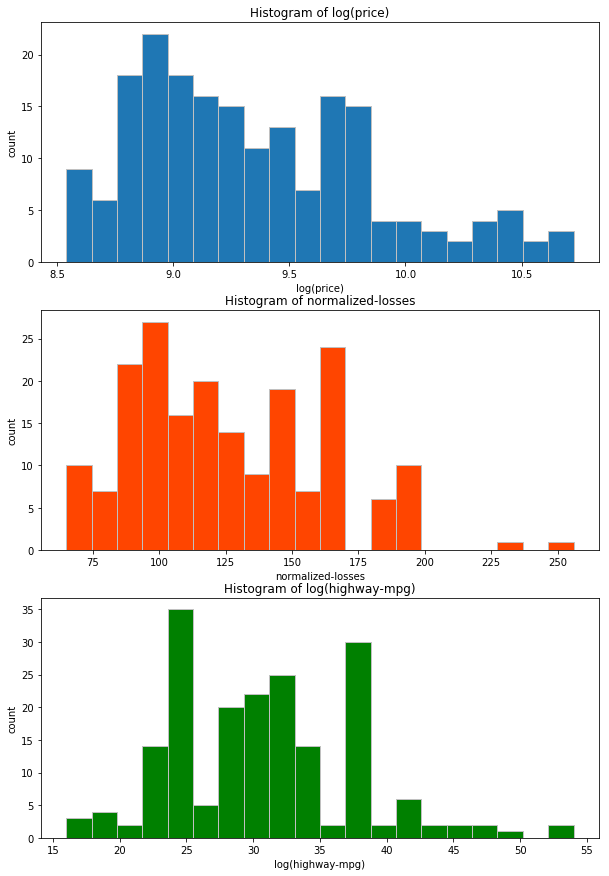

In [12]:
ax=plt.figure(figsize=(10,15)).gca()

plt.subplot(3,1,1)
plt.hist(np.log(df.price), edgecolor="silver", bins=20, color='C0')
plt.title("Histogram of log(price)")
plt.xlabel("log(price)")
plt.ylabel("count")

plt.subplot(3,1,2)
plt.hist(df['normalized-losses'], edgecolor="silver", bins=20, color="orangered")
plt.title("Histogram of normalized-losses")
plt.xlabel("normalized-losses")
plt.ylabel("count")

plt.subplot(3,1,3)
plt.hist(df['highway-mpg'], edgecolor="silver", bins=20, color='green')
plt.title("Histogram of log(highway-mpg)")
plt.xlabel("log(highway-mpg)")
plt.ylabel("count")

_=""


### QQ Plots
Our three features appear to be approximately normally-distributed. Let's 
try out QQ plots to see how well each matches the normal distribution

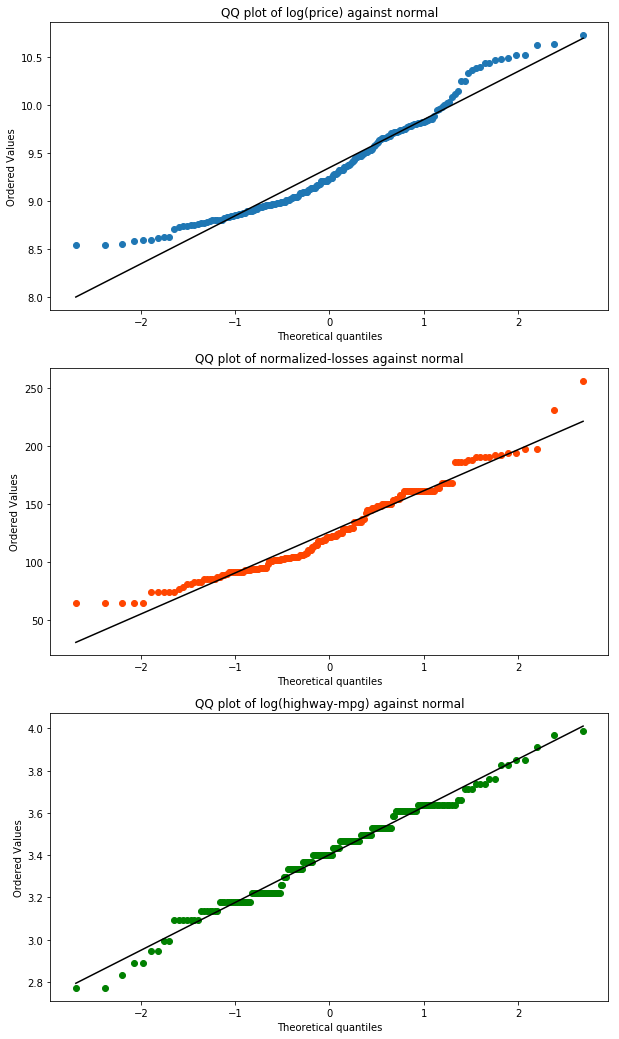

In [13]:
plt.figure(figsize=(10,18)).gca()

ax=plt.subplot(3,1,1)
pp1=scipy.stats.probplot(np.log(df.price), plot=ax, dist='norm')
#https://stackoverflow.com/questions/37463189/change-marker-style-color-in-python-probplot?rq=1
ax.get_lines()[0].set_color('C0')
ax.get_lines()[1].set_color('black')

ax.set_title("QQ plot of log(price) against normal")

ax=plt.subplot(3,1,2)
scipy.stats.probplot(df['normalized-losses'], plot=ax, dist='norm')
ax.get_lines()[0].set_color('orangered')
ax.get_lines()[1].set_color('black')
ax.set_title("QQ plot of normalized-losses against normal")

ax=plt.subplot(3,1,3)
scipy.stats.probplot(np.log(df['highway-mpg']), plot=ax, dist='norm')
ax.get_lines()[0].set_color('green')
ax.get_lines()[1].set_color('black')
ax.set_title("QQ plot of log(highway-mpg) against normal")

_=""

### K-S tests against normal distribution
The three features appear to be somewhat normal, but let's use K-S tests to ensure fit. We'll use the 95% level of confidence (alpha=0.05) to determine whether we can reject the null hypothesis, that the feature is distributed normally.

In [14]:
# copy ks test from notebook
def ks_test(dat, dist = 'norm'):
    ks_statisic, pvalue = scipy.stats.kstest(dat, dist)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))   
    
# copy the plotting function from the notebook, to illustrate
# our calculations.
def plot_cums(dist1, dist2, axtitle):
    ## sort the first data sample:
    data_sorted = np.sort(dist1)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(dist1)) / (len(dist1) - 1)

    # Now plot as line and scatter plot. 
    plt.plot(data_sorted, p)
    plt.scatter(data_sorted, p, color = 'red')
    
    # sort the second data sample:
    data_sorted = np.sort(dist2)
    
    # And the second plot
    plt.plot(data_sorted, p, color = 'yellow')
    plt.scatter(data_sorted, p, color = 'green')
    
    plt.title(axtitle)    
    
# and here's my own routine to supply a random sampling of
# a standard normal distribution, to help visually compare
# results of K-S test
def create_sample_norm(s=100):
    return scipy.stats.norm.rvs(size=s) 

For 'log(price)':
KS-statistic = 0.10161551154
P-value = 0.0345591936411


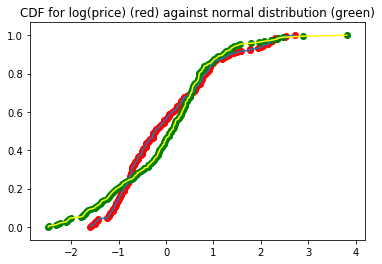

In [15]:
# perform a K-S test on log(price) vs. normal distribution
from sklearn.preprocessing import scale
print("For 'log(price)':")
price = scale(np.log(df['price']))
ks_test(price)
plot_cums(price, create_sample_norm(len(price)), 
          "CDF for log(price) (red) against normal distribution (green)") 

For 'normalized-losses':
KS-statistic = 0.105344035175
P-value = 0.025564960568


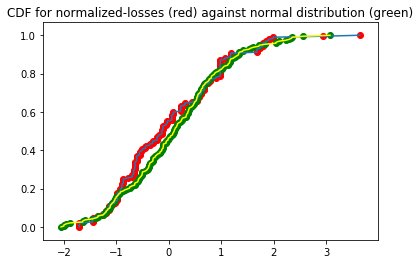

In [16]:
# perform a K-S test on normalized-losses vs. normal distribution
print("For 'normalized-losses':")
normalized_losses = scale(df['normalized-losses'])
ks_test(normalized_losses)
plot_cums(normalized_losses, create_sample_norm(len(normalized_losses)), 
          "CDF for normalized-losses (red) against normal distribution (green)") 

For 'log(highway-mpg)':
KS-statistic = 0.0926708799574
P-value = 0.0681387185343


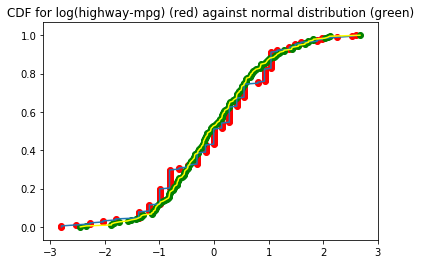

In [17]:
# perform a K-S test on log(highway-mpg) vs. normal distribution
print("For 'log(highway-mpg)':")
highway_mpg = scale(np.log(df['highway-mpg']))
ks_test(highway_mpg)
plot_cums(highway_mpg, create_sample_norm(len(highway_mpg)), 
          "CDF for log(highway-mpg) (red) against normal distribution (green)") 

### Result: One of the three features is distributed normally
The K-S test confirms that one feature, log(highway-mpg), is distributed normally. Its p-value is 0.07, which is larger than the 95% confidence level (alpha=0.05) we selected.

The other features, log(price) and normalized-losses, have p-values of 0.035 and 0.026 respectively. Since those values are lower than our alpha of 0.05, we must reject the null hypothesis that the distributions are normal. 

# 3. Summary statistics
Compute the summary statistics for our three features. We'll calculate:

* Mean
* Standard deviation
* 95% confidence intervals ("credible intervals" for Bayes)

using three different approaches: classical, bootstrap, and Bayesian.

In [18]:
# accumulate results in this dataframe for summary:
mi=pd.MultiIndex.from_product([['Feature1','Feature2','Feature3'],['mean','std','CI95low','CI95high']])
stats = pd.DataFrame(columns=mi, index=['classical','bootstrap','bayes'])
#stats.loc['classical','Feature1'].stdev
stats

Feature1                       Feature2                        \
              mean  std CI95low CI95high     mean  std CI95low CI95high   
classical      NaN  NaN     NaN      NaN      NaN  NaN     NaN      NaN   
bootstrap      NaN  NaN     NaN      NaN      NaN  NaN     NaN      NaN   
bayes          NaN  NaN     NaN      NaN      NaN  NaN     NaN      NaN   

          Feature3                        
              mean  std CI95low CI95high  
classical      NaN  NaN     NaN      NaN  
bootstrap      NaN  NaN     NaN      NaN  
bayes          NaN  NaN     NaN      NaN

## Classical
Warm-up by calculating mean and standard deviation traditionally from the feature values.

### log(price)

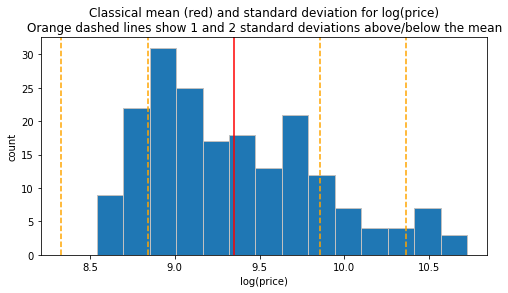

Classical statistics for log(price):
Mean: 9.348497160605326
Standard deviation: 0.5087063857154399


In [19]:
# start with log(price)
data = np.log(df['price'])
mean=data.mean()
std=data.std()

# simple plot to illustrate distribution, mean and standard deviation:
def plot_simple(data,mean,std,feature='feature',color='C0'):
    plt.figure(figsize=(8,4))
    plt.hist(data,edgecolor='silver',bins=14,color=color)
    plt.axvline(mean,color='red')
    plt.axvline(mean-std, color='orange', linestyle='--')
    plt.axvline(mean-2*std, color='orange', linestyle='--')
    plt.axvline(mean+std, color='orange', linestyle='--')
    plt.axvline(mean+2*std, color='orange', linestyle='--')
    plt.xlabel(feature)
    plt.ylabel("count")
    plt.title("Classical mean (red) and standard deviation for "+feature+\
              "\nOrange dashed lines show 1 and 2 standard deviations above/below the mean")
    plt.show()
    
plot_simple(data,mean,std,feature='log(price)',color='C0')    

# values:
print("Classical statistics for log(price):")
print("Mean:", mean)
print("Standard deviation:", std)

# store for later:
stats.loc['classical','Feature1']['mean'] = mean
stats.loc['classical','Feature1']['std'] = std


Find the 95% confidence interval around this observed mean. We want to find the likelihood that the actual, true population mean falls within a certain range of the mean we found. We specify that in only 1 in 20 samples of n observations should the true mean fall outside the interval.

$$
C.I. = mean \pm z_c \cdot \sigma_{\bar{x}}  \\
where\ z_c\ is\ the\ critical\ z\ score\ and  \\
\sigma_{\bar{x}} = \frac{\sigma}{\sqrt{n}}
$$



In [20]:
# 95% ci for the observed mean. this uses 1.96 as the critical z-score (95%),
# and approximates the population sigma with that of the observed data 
# (we have more than 30 observations, so this is a good approximation).
def classical_ci(x):
    low =  x.mean() - 1.96 * x.std()/np.sqrt(len(x))
    high = x.mean() + 1.96 * x.std()/np.sqrt(len(x))
    return low,high
    
lo,hi = classical_ci(data)

# store for later:
stats.loc['classical','Feature1']['CI95low'] = lo
stats.loc['classical','Feature1']['CI95high'] = hi

### normalized-losses

Now do normalized-losses

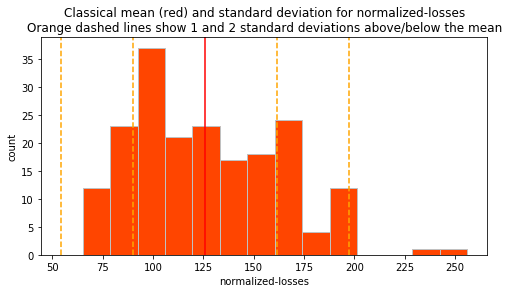

Classical statistics for normalized-losses:
Mean: 125.91273051423478
Standard deviation: 35.78174263168556


In [21]:
# and do normalized-losses
data = df['normalized-losses']
mean=data.mean()
std=data.std()

# plot to illustrate values:
plot_simple(data,mean,std,feature='normalized-losses',color='orangered')  

# values:
print("Classical statistics for normalized-losses:")
print("Mean:", mean)
print("Standard deviation:", std)

# store for later:
stats.loc['classical','Feature2']['mean'] = mean
stats.loc['classical','Feature2']['std'] = std

In [22]:
# get the 95% confidence interval
lo,hi = classical_ci(data)

# store for later:
stats.loc['classical','Feature2']['CI95low'] = lo
stats.loc['classical','Feature2']['CI95high'] = hi

### log(highway-mpg)

Finally do log(highway-mpg)

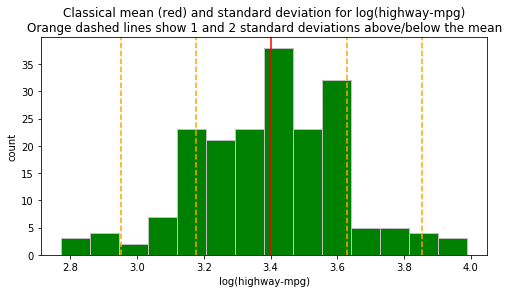

Classical statistics for log(highway-mpg):
Mean: 3.4023512542083294
Standard deviation: 0.22601002523958752


In [23]:
# and finally log(highway-mpg)
data = np.log(df['highway-mpg'])
mean=data.mean()
std=data.std()

# plot to illustrate values:
plot_simple(data,mean,std,feature='log(highway-mpg)',color='green')  

# values:
print("Classical statistics for log(highway-mpg):")
print("Mean:", mean)
print("Standard deviation:", std)

# store for later:
stats.loc['classical','Feature3']['mean'] = mean
stats.loc['classical','Feature3']['std'] = std

In [24]:
# get the 95% confidence interval
lo,hi = classical_ci(data)

# store for later:
stats.loc['classical','Feature3']['CI95low'] = lo
stats.loc['classical','Feature3']['CI95high'] = hi

### Results: Classical mean,  standard deviation and confidence intervals

In [25]:
# stats so far:
stats

Feature1                             Feature2                    \
              mean       std  CI95low CI95high     mean      std  CI95low   
classical   9.3485  0.508706  9.27673  9.42027  125.913  35.7817  120.865   
bootstrap      NaN       NaN      NaN      NaN      NaN      NaN      NaN   
bayes          NaN       NaN      NaN      NaN      NaN      NaN      NaN   

                   Feature3                             
          CI95high     mean      std  CI95low CI95high  
classical  130.961  3.40235  0.22601  3.37046  3.43424  
bootstrap      NaN      NaN      NaN      NaN      NaN  
bayes          NaN      NaN      NaN      NaN      NaN

## Bootstrap - summary stats
Use bootstrap techniques to estimate the mean, standard deviation and confidence intervals of the three features.

In [26]:
# library from the notebook

# the confidence interval for bootstrap is just the empiracle spread of
# the distribution of the parameter
def plot_bootstrap(x, p=5,feature='feature',color='C0'):
    # Plot the distribution and mark the mean
    plt.hist(x, edgecolor='silver',bins=20,color=color)
    plt.axvline(x.mean(),color='red')
    # central 100*(1-p)% of data   
    low= np.percentile(x, p/2.)
    high=np.percentile(x, 100-p/2.)
    plt.axvline(low, color='orange', linewidth=2, linestyle='--')
    plt.axvline(high, color='orange', linewidth=2, linestyle='--')
    plt.xlabel(feature)
    plt.title("Histogram of means for bootstrapped resamples for {}\n\
        Confidence interval is {} to {}".format(feature,float('%.4g' % low),float('%.4g' % high)))
    plt.show()
    return low,high

# simple function to compute the bootstrap mean and estimated population std of any set of data.
# also calls a plot routine that computes 95% confidence intervals.
def bootstrap_stats(data,feature='log(price)',color='C0'):
    n_replicas = 10000 # run the bootstrap this many times
    data_means = pd.Series([data.sample(frac=1, replace=True).mean() for i in range(n_replicas)])
    # population std estimated as sqrt(n) * stdev(sample means) per Central Limit Theorem
    pop_std = data_means.std() * np.sqrt(len(data))
    lo,hi = plot_bootstrap(data_means,feature=feature,color=color)
    return data_means.mean(),pop_std,lo,hi

### log(price)

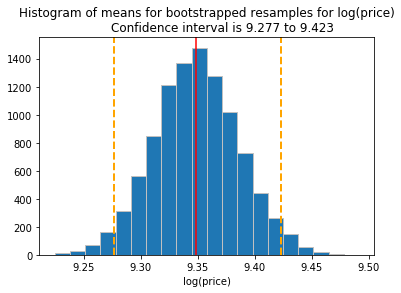

Bootstrapped statistics for log(price):
Mean: 9.34878486353265
Standard deviation: 0.513214290357
95% low confidence interval: 9.27655878313
95% high confidence interval: 9.42286098742


In [27]:
# do log(price) first
data=np.log(df.price)
mean, std, low, high = bootstrap_stats(data,feature='log(price)',color='C0')

# confidence interval
#low,high = plot_bootstrap(data,feature='log(price)',color='C0')   

# values:
print("Bootstrapped statistics for log(price):")
print("Mean:", mean)
print("Standard deviation:", std)
print("95% low confidence interval:",low)
print("95% high confidence interval:",high)

# store for later:
stats.loc['bootstrap','Feature1']['mean'] = mean
stats.loc['bootstrap','Feature1']['std'] = std
stats.loc['bootstrap','Feature1']['CI95low'] = low
stats.loc['bootstrap','Feature1']['CI95high'] = high

### normalized-losses

Now do normalized-losses

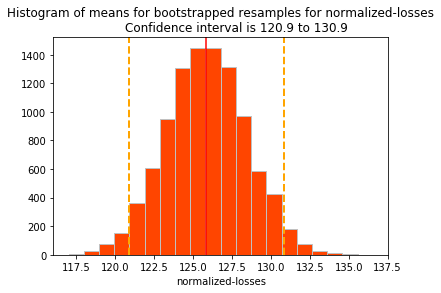

Bootstrapped statistics for normalized-losses:
Mean: 125.84258782829107
Standard deviation: 35.8923991657
95% low confidence interval: 120.859578528
95% high confidence interval: 130.87359052


In [28]:
# now normalized-losses
data=df['normalized-losses']
mean, std, low, high = bootstrap_stats(data,feature='normalized-losses',color='orangered')

# values:
print("Bootstrapped statistics for normalized-losses:")
print("Mean:", mean)
print("Standard deviation:", std)
print("95% low confidence interval:",low)
print("95% high confidence interval:",high)

# store for later:
stats.loc['bootstrap','Feature2']['mean'] = mean
stats.loc['bootstrap','Feature2']['std'] = std
stats.loc['bootstrap','Feature2']['CI95low'] = low
stats.loc['bootstrap','Feature2']['CI95high'] = high

### log(highway-mpg)

And finally highway-mpg

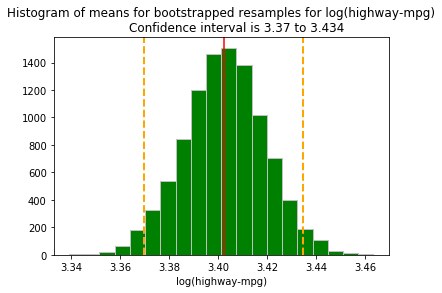

Bootstrapped statistics for log(highway-mpg):
Mean: 3.402472974906815
Standard deviation: 0.228993420655
95% low confidence interval: 3.36951200548
95% high confidence interval: 3.43442812298


In [29]:
# and finally log(highway-mpg)
data=np.log(df['highway-mpg'])
mean, std, low, high = bootstrap_stats(data,feature='log(highway-mpg)',color='green')

# values:
print("Bootstrapped statistics for log(highway-mpg):")
print("Mean:", mean)
print("Standard deviation:", std)
print("95% low confidence interval:",low)
print("95% high confidence interval:",high)

# store for later:
stats.loc['bootstrap','Feature3']['mean'] = mean
stats.loc['bootstrap','Feature3']['std'] = std
stats.loc['bootstrap','Feature3']['CI95low'] = low
stats.loc['bootstrap','Feature3']['CI95high'] = high

### Result: Bootstrapped mean and standard deviation

In [30]:
stats

Feature1                             Feature2                    \
              mean       std  CI95low CI95high     mean      std  CI95low   
classical   9.3485  0.508706  9.27673  9.42027  125.913  35.7817  120.865   
bootstrap  9.34878  0.513214  9.27656  9.42286  125.843  35.8924   120.86   
bayes          NaN       NaN      NaN      NaN      NaN      NaN      NaN   

                   Feature3                              
          CI95high     mean       std  CI95low CI95high  
classical  130.961  3.40235   0.22601  3.37046  3.43424  
bootstrap  130.874  3.40247  0.228993  3.36951  3.43443  
bayes          NaN      NaN       NaN      NaN      NaN

## Bayes - summary stats
Use Bayesian techniques to estimate the mean and standard deviation of the three features. This section will be more interesting. 

Let's operate in the spirit of Bayes by fabricating an experiment. Since we want to calculate 

$$
posterior \propto likelihood * prior
$$

let's do the following:

1. Take a subset of our full dataset. This smaller set of data is what we'll use in the likelihood factor for our "data."
2. Use the full dataset to provide notions of what our priors should be (distribution of the mean).
3. Calculate the posterior, in which the prior should effectively nudge the statistics of the subset towards those of the full dataset.

In [31]:
# copy over some library routines from the notebook

# likelihood function
# since we're going after the mean of the distribution, use a normal as the shape of our
# likelihood function. 
def compute_like(p, x): 
    variance = np.std(x)**2 # sigmasqr
    x_mean = np.asarray(x).mean()  # xbar
    print('Data mean = %.3f, Data standard deviation = %.3f' % (x_mean, np.std(x)))
    n = len(x)
    l = np.exp(-n * np.square(x_mean - p) / (2 * variance))
    return l / l.sum()

def compute_posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity

def plot_post(prior, like, post, x):
    maxy = max(max(prior), max(like), max(post))
    plt.figure(figsize=(12, 4))
    plt.plot(x, like, label='likelihood', linewidth=8, color='black', alpha=.2)
    plt.plot(x, prior, label='prior')
    plt.plot(x, post, label='posterior', color='green')
    plt.ylim(0, maxy*1.02)
    #plt.xlim(0, 100)
    plt.title('Density of prior, likelihood and posterior')
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.legend()
    
def calc_ci(p, post, lower_q, upper_q, make_plot=True):
    ## This function computes a credible interval using an assumption
    ## of symmetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## returns a tuple of the (low,high) interval
    ## Compute a large sample by resampling with replacement
    num_samples = 100000
    samples = np.random.choice(p, size=num_samples, replace=True, p=post)
    ci = scipy.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    if make_plot:
        interval = upper_q - lower_q
        plt.title('Posterior density with %.3f credible interval' % interval)
        plt.plot(p, post, color='blue')
        plt.xlabel('Parameter value')
        plt.ylabel('Density')
        plt.axvline(x=ci[0], color='red')
        plt.axvline(x=ci[1], color='red')
        print('The %.3f credible interval is %.3f to %.3f' 
          % (interval, ci[0], ci[1]))    
        
    return ci[0],ci[1]    

#### Look at log(price) first

Data mean = 9.405, Data standard deviation = 0.487


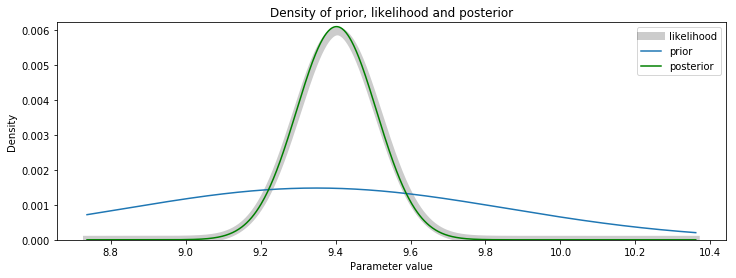

In [32]:
# grab a subset of our full data. the smaller the subset, the more interesting
# this will be (smile).
n_subset = 20 # how big should our subset be? the original dataset is 193 records
subset = df.sample(n=n_subset,replace=False)
data = np.log(subset.price)

# get a few values from the full dataset for this feature:
canonical_mean = np.log(df.price).mean() # these will be used 
canonical_std = np.log(df.price).std()   #  in the likelihood function

# we want to estimate the mean. the mean is our "parameter."
# range of the subset over which we'll estimate our parameter's probability
p = np.linspace(data.min(),data.max(),num=1000)

# create a prior. the parameters (mean, std) are based on the full dataset.
# our prior is normal in shape, centered at the full dataset's mean and with
# its variance.
pp = scipy.stats.norm.pdf(p, loc=canonical_mean, scale=canonical_std)
pp = pp / pp.sum() # normalize

# compute likelihood and posterior
likelihood = compute_like(p, data)
post = compute_posterior(pp, likelihood)

# and plot everything
plot_post(pp, likelihood, post, p)

In [33]:
# pick out the mode of the mean as predicted by the posterior, for interest sake
mode = pd.DataFrame({'x':p, 'y':post}).sort_values(by='y',ascending=False).iloc[0][0]
print("Mode of parameter according to posterior = ",mode)
print("Initial subset data mean = ",data.mean())
print("Nudge provided by prior = {}%".format(100*np.abs((mode-data.mean())/data.mean())))

Mode of parameter according to posterior =  9.40182793967
Initial subset data mean =  9.40501786794863
Nudge provided by prior = 0.033917301674806506%


In [34]:
# values:
print("Bayes statistics for log(price):")
print("Mean:", mode)

# store for later:
stats.loc['bayes','Feature1']['mean'] = mode

Bayes statistics for log(price):
Mean: 9.40182793967


Compute the credible interval, the Bayesian analog to confidence interval

The 0.950 credible interval is 9.192 to 9.612


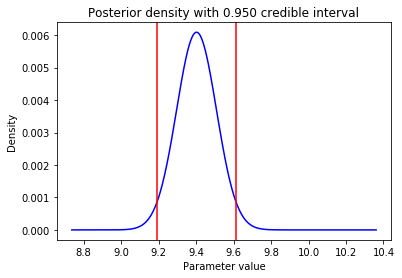

In [35]:
# compute the credible interval
lower_q, upper_q = [.025, .975]
lo,hi = calc_ci(p, post, lower_q, upper_q)

# store for later:
stats.loc['bayes','Feature1']['CI95low'] = lo
stats.loc['bayes','Feature1']['CI95high'] = hi

#### Repeat for normalized-losses

Data mean = 123.650, Data standard deviation = 28.580


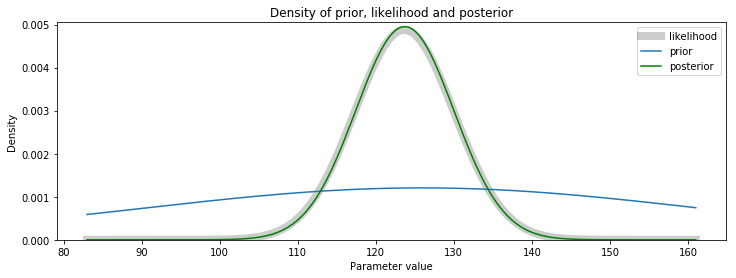

In [36]:
# now do normalized-losses
data = subset['normalized-losses']

# get a few values from the full dataset for this feature:
canonical_mean = df['normalized-losses'].mean() # these will be used 
canonical_std = df['normalized-losses'].std()   #  in the likelihood function

# we want to estimate the mean. the mean is our "parameter."
# range of the subset over which we'll estimate our parameter's probability
p = np.linspace(data.min(),data.max(),num=1000)

# create a prior. the parameters (mean, std) are based on the full dataset.
# our prior is normal in shape, centered at the full dataset's mean and with
# its variance.
pp = scipy.stats.norm.pdf(p, loc=canonical_mean, scale=canonical_std)
pp = pp / pp.sum() # normalize

# compute likelihood and posterior
likelihood = compute_like(p, data)
post = compute_posterior(pp, likelihood)

# and plot everything
plot_post(pp, likelihood, post, p)

In [37]:
# pick out the mode of the mean as predicted by the posterior, for interest sake
mode = pd.DataFrame({'x':p, 'y':post}).sort_values(by='y',ascending=False).iloc[0][0]
print("Mode of parameter according to posterior = ",mode)
print("Initial subset data mean = ",data.mean())
print("Nudge provided by prior = {}%".format(100*np.abs((mode-data.mean())/data.mean())))

Mode of parameter according to posterior =  123.756756757
Initial subset data mean =  123.65
Nudge provided by prior = 0.08633785423109763%


In [38]:
# values:
print("Bayes statistics for normalized-losses:")
print("Mean:", mode)

# store for later:
stats.loc['bayes','Feature2']['mean'] = mode

Bayes statistics for normalized-losses:
Mean: 123.756756757


Compute the credible interval, the Bayesian analog to confidence interval

The 0.950 credible interval is 111.498 to 136.015


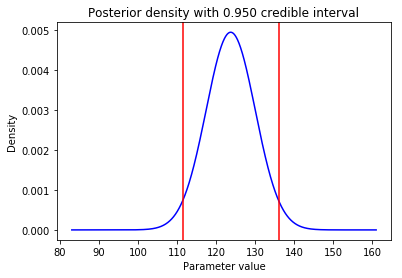

In [39]:
# compute the credible interval
lower_q, upper_q = [.025, .975]
lo,hi = calc_ci(p, post, lower_q, upper_q)

# store for later:
stats.loc['bayes','Feature2']['CI95low'] = lo
stats.loc['bayes','Feature2']['CI95high'] = hi

#### Repeat for log(highway-mpg)

Data mean = 3.411, Data standard deviation = 0.169


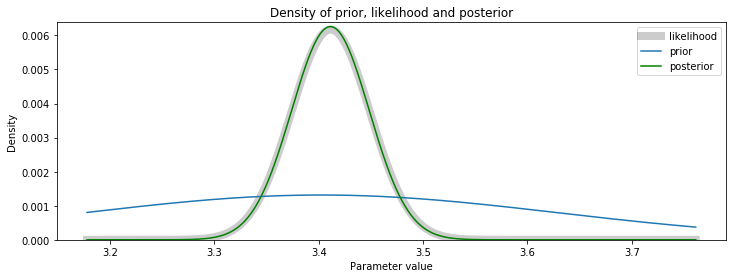

In [40]:
# now do log(highway-mpg)
data = np.log(subset['highway-mpg'])

# get a few values from the full dataset for this feature:
canonical_mean = np.log(df['highway-mpg']).mean() # these will be used 
canonical_std = np.log(df['highway-mpg']).std()   #  in the likelihood function

# we want to estimate the mean. the mean is our "parameter."
# range of the subset over which we'll estimate our parameter's probability
p = np.linspace(data.min(),data.max(),num=1000)

# create a prior. the parameters (mean, std) are based on the full dataset.
# our prior is normal in shape, centered at the full dataset's mean and with
# its variance.
pp = scipy.stats.norm.pdf(p, loc=canonical_mean, scale=canonical_std)
pp = pp / pp.sum() # normalize

# compute likelihood and posterior
likelihood = compute_like(p, data)
post = compute_posterior(pp, likelihood)

# and plot everything
plot_post(pp, likelihood, post, p)

In [41]:
# pick out the mode of the mean as predicted by the posterior, for interest sake
mode = pd.DataFrame({'x':p, 'y':post}).sort_values(by='y',ascending=False).iloc[0][0]
print("Mode of parameter according to posterior = ",mode)
print("Initial subset data mean = ",data.mean())
print("Nudge provided by prior = {}%".format(100*np.abs((mode-data.mean())/data.mean())))

Mode of parameter according to posterior =  3.41096210648
Initial subset data mean =  3.4114739459464487
Nudge provided by prior = 0.015003469983440671%


In [42]:
# values:
print("Bayes statistics for log(highway-mpg):")
print("Mean:", mode)

# store for later:
stats.loc['bayes','Feature3']['mean'] = mode

Bayes statistics for log(highway-mpg):
Mean: 3.41096210648


Compute the credible interval, the Bayesian analog to confidence interval

The 0.950 credible interval is 3.339 to 3.485


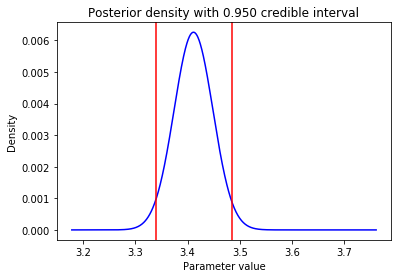

In [43]:
# compute the credible interval
lower_q, upper_q = [.025, .975]
lo,hi = calc_ci(p, post, lower_q, upper_q)

# store for later:
stats.loc['bayes','Feature3']['CI95low'] = lo
stats.loc['bayes','Feature3']['CI95high'] = hi

## Section summary
In this section we computed summary statistics for the features, using the three different approaches (classial, bootstrap and bayesian). Let's look at the results numerically, and also in a visualization.

Graphical display for visual comparison

In [44]:
# simple routine to graphically display points and confidence intervals around those
# points. send in an array of tuples of points points like this:
#
#  (x,y,x1,x2,label) 
#
#  where (x,y) is the point, (x1,x2) is the line, and label is the label
#
# e.g., 
# points = [(.5,.5,.4,.6,'Alpha'),
#           (.55,.65,.3,.62,'Beta'),
#           (.15,.35,.05,.22,'Gamma')]
# plot_points(points)

def plot_points(points,title="",xlabel=""):
    xmin,xmax,ymin,ymax=0,0,0,0

    i=0
    for (x,y,x1,x2,label) in points:
        if(i==0):
            xmin,xmax,ymin,ymax=x1,x2,y,y
            i+=1
        plt.scatter(x,y,label=label,s=100)
        plt.hlines(y,x1,x2)
        xmin = min(xmin,x1)
        xmax = max(xmax,x2)
        ymin = min(ymin,y)
        ymax = max(ymax,y)    
        
    xdiff = xmax-xmin
    ydiff = ymax-ymin
    plt.xlim(xmin-.2*xdiff,xmax+.2*xdiff)
    plt.ylim(ymin-.2*ydiff,ymax+.6*ydiff)
    
    #kill the y axis which is not meaningful
    plt.yticks([])
    
    plt.title(title)
    plt.xlabel(xlabel)
    
    plt.legend()
    plt.show()
#plot_points(points)

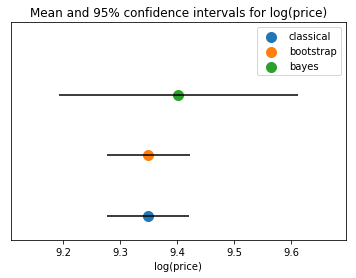

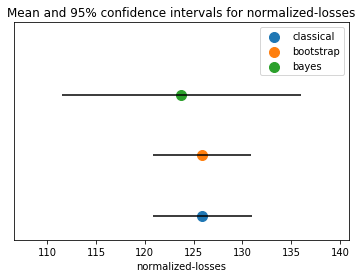

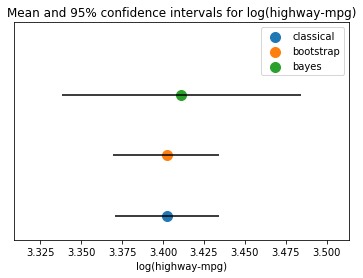

In [45]:
# and display the results graphically
methods = ['classical','bootstrap','bayes']
vis = [
    ('Feature1','log(price)'),
    ('Feature2','normalized-losses'),
    ('Feature3','log(highway-mpg)')
]
for (feat,label) in vis:
    points = []
    data = stats.loc[:,feat]
    i=1
    for j in methods:
        points.append((data.loc[j]['mean'],i,data.loc[j]['CI95low'],data.loc[j]['CI95high'],j))
        i+=1
    plot_points(points,title="Mean and 95% confidence intervals for "+label,xlabel=label)    

Numeric results

In [46]:
stats

Feature1                             Feature2                    \
              mean       std  CI95low CI95high     mean      std  CI95low   
classical   9.3485  0.508706  9.27673  9.42027  125.913  35.7817  120.865   
bootstrap  9.34878  0.513214  9.27656  9.42286  125.843  35.8924   120.86   
bayes      9.40183       NaN  9.19213  9.61153  123.757      NaN  111.498   

                   Feature3                              
          CI95high     mean       std  CI95low CI95high  
classical  130.961  3.40235   0.22601  3.37046  3.43424  
bootstrap  130.874  3.40247  0.228993  3.36951  3.43443  
bayes      136.015  3.41096       NaN  3.33856  3.48451

Feature1 = log(price)  
Feature2 = normalized-losses  
Feature3 = log(highway-mpg)

### Classical and Bootstrap methods
The resulting mean estimate turn out to be remarkably similar, differing only by a couple parts per thousand. The variance in the classical and bootstrap approaches are similarly close. Confidence intervals, based on the sample size of 194, are appropriately tightly aligned to the observed means.

### Bayesian method
Because our Bayes experiments are purposefully using small samples of our data (in order to test the effect of priors), our Bayes means and credible intervals diverge (and are wider) than those of classical and bootstrap. The means aren't too far off those from the other methods (see graphical visualization, below), about 3% apart at the most different (depends on the particular run). The credible intervals for Bayes method is about 3 times wider than the confidence intervals of the other methods, again since the sample size was (purposefully) much smaller.

# 4. Use hypothesis test to find significance in subsets of data
In this final section, let's look at subsets of price, normalized-losses and highway-mpg to see if any other features have signficant predictive power on them. We'll do this by dividing one feature by the several categories, and seeing if those subsets have significantly different mean values. We do this in several ways:

* Classical (e.g., t-test)
* Tukey HSD (for multiple categories)
* Bootstrap
* Bayes

In [47]:
df.describe(include=['O'])

make fuel-type aspiration num-of-doors body-style drive-wheels  \
count      193       193        193          193        193          193   
unique      18         2          2            2          5            3   
top     toyota       gas        std         four      sedan          fwd   
freq        32       173        158          113         93          116   

       engine-location engine-type num-of-cylinders fuel-system  
count              193         193              193         193  
unique               2           6                7           7  
top              front         ohc             four        mpfi  
freq               190         140              150          86

In [48]:
df.head()

symboling  normalized-losses  make fuel-type aspiration num-of-doors  \
3          2              164.0  audi       gas        std         four   
4          2              164.0  audi       gas        std         four   
5          2              161.0  audi       gas        std          two   
6          1              158.0  audi       gas        std         four   
7          1              161.0  audi       gas        std         four   

  body-style drive-wheels engine-location  wheel-base   ...     engine-size  \
3      sedan          fwd           front        99.8   ...             109   
4      sedan          4wd           front        99.4   ...             136   
5      sedan          fwd           front        99.8   ...             136   
6      sedan          fwd           front       105.8   ...             136   
7      wagon          fwd           front       105.8   ...             136   

   fuel-system  bore  stroke compression-ratio horsepower  peak-rpm city-mpg  \
3         mpfi  3.19     3.4              10.0      102.0    5500.0       24   
4         mpfi  3.19     3.4               8.0      115.0    5500.0       18   
5         mpfi  3.19     3.4               8.5      110.0    5500.0       19   
6         mpfi  3.19     3.4               8.5      110.0    5500.0       19   
7         mpfi  3.19     3.4               8.5      110.0    5500.0       19   

   highway-mpg    price  
3           30  13950.0  
4           22  17450.0  
5           25  15250.0  
6           25  17710.0  
7           25  18920.0  

[5 rows x 26 columns]

## Classical
Let's start simply with some features that have 2 categories (each) and use the traditional t-test to check out significance.

### Testing: num-of-cylinders on log(highway-mpg)
I predict that num-of-cylinders will have a significance on log(highway-mpg). Let's test this out. Use only num-of-cylinders that have more than 10 observations.

In [49]:
df['num-of-cylinders'].value_counts()[ df['num-of-cylinders'].value_counts()>10 ]

four    150
six      23
Name: num-of-cylinders, dtype: int64

In [50]:
df1=df[df['num-of-cylinders']=='four']['highway-mpg']
df2=df[df['num-of-cylinders']=='six']['highway-mpg']

# convert to log()
df1=np.log(df1)
df2=np.log(df2)

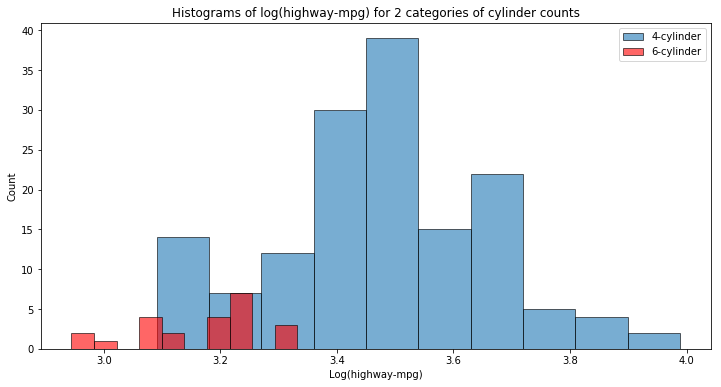

In [51]:
# let's do simple overlain histograms to see if the distributions
# are similar

ax=plt.figure(figsize=(12,6)).gca()
plt.hist(df1,color='C0',edgecolor='black',alpha=0.6,label="4-cylinder")
plt.hist(df2,color='red',edgecolor='black',alpha=0.6,label="6-cylinder")
ax.set_title("Histograms of log(highway-mpg) for 2 categories of cylinder counts")
ax.set_xlabel("Log(highway-mpg)")
ax.set_ylabel("Count")
ax.legend()
_=""

It's looking good that the higher the cylinder count, the lower the highway-mpg. Let's do a formal t-test and see if this comes true.

In [52]:
# copy the t-test code from the notebook
def t_test(a, b, alpha=.05, alternative='two-sided'):
    from scipy import stats
    import scipy.stats as ss
    import pandas as pd
    import statsmodels.stats.weightstats as ws
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b) # generate a t-statistic from a and b 
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b)) # create an opbject containing both sets of data

    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') # generate the confidence interval for the difference in means
    degfree = means.dof_satt() # effective degrees of freedom of Satterthwaite for unequal variance. https://en.wikipedia.org/wiki/Welch%E2%80%93Satterthwaite_equation
    
    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   
  
# copy the plotting routines from the notebook
def hist_mean_ci(vec, t_test, bins):
    import matplotlib.pyplot as plt
    from statistics import mean
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins = bins,edgecolor='silver')
    plt.axvline(mean(vec), color = 'red')
    plt.axvline(upper, color = 'orange', linestyle='--')
    plt.axvline(lower, color = 'orange', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

def plot_t(a, b, t_test, cols=['pop_A', 'pop_B'], nbins = 20, feature_name='feature'):
    import matplotlib.pyplot as plt
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.figure(figsize=(10,7))
    plt.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histogram of '+ feature_name + ' for ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)
    
def hist_plot(vec, bins):
    import matplotlib.pyplot as plt
    from statistics import mean
    #plt.figure(figsize=(6,6))
    plt.hist(vec, bins = bins,edgecolor='silver')
    plt.axvline(mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    
# use like this:
#test = t_test(pop_A, pop_B)
#plot_t(pop_A, pop_B, test) 

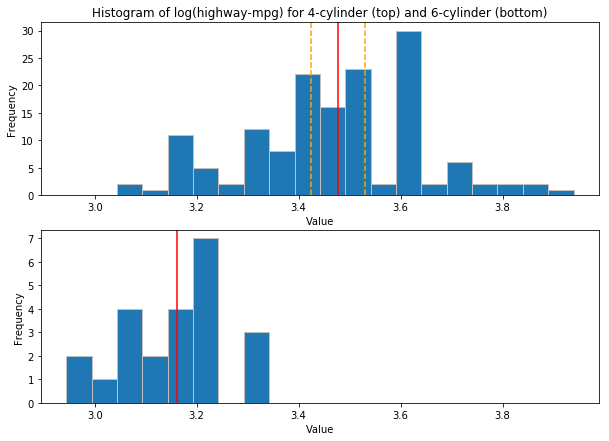

In [53]:
# perform a t-test to see if the means of the populations 
# can be considered the same
test = t_test(df1,df2)

# and plot
plot_t(df1,df2,test,cols=['4-cylinder (top)','6-cylinder (bottom)'],feature_name='log(highway-mpg)')

In [54]:
print("Testing impact of num-of-cylinders feature on log(highway-mpg)")
test

Testing impact of num-of-cylinders feature on log(highway-mpg)


DegFreedom    4.375289e+01
Difference    3.144784e-01
Statistic     8.331628e+00
PValue        2.496746e-14
Low95CI       2.616274e-01
High95CI      3.673294e-01
dtype: float64

#### Result: num-of-cylinders DOES have an effect on highway-mpg
As expected, cars with lower num-of-cylinders do have higher highway-mpg than cars with higher num-of-cylinders. We proved this by doing a t-test under the null hypothesis that num-of-cylinders has no effect on highway-mpg. The p-value turned out to be vanishingly small, so we conclude that the difference in means (.314 for log(highway-mpg), or 1.37 mpg for highway-mpg), IS statistically signficant.

### Testing: num-of-doors on normalized-losses
I wonder whether num-of-doors will have any significance on normalized-losses. Let's test this out. We have 2- and 4-door cars

In [55]:
df['num-of-doors'].value_counts()[ df['num-of-doors'].value_counts()>10 ]

four    113
two      80
Name: num-of-doors, dtype: int64

In [56]:
df1=df[df['num-of-doors']=='two']['normalized-losses']
df2=df[df['num-of-doors']=='four']['normalized-losses']

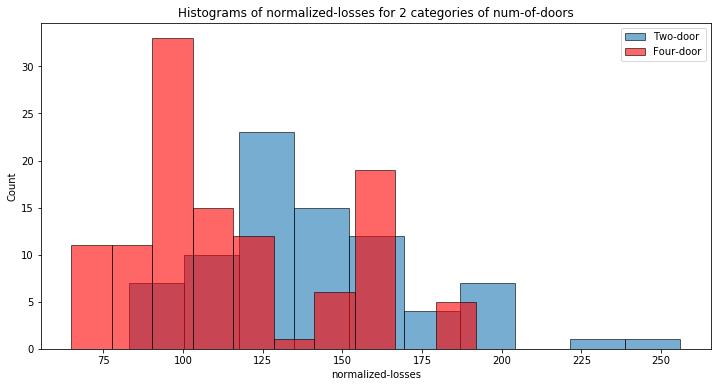

In [57]:
# let's do simple overlain histograms to see if the distributions
# are similar

ax=plt.figure(figsize=(12,6)).gca()
plt.hist(df1,color='C0',edgecolor='black',alpha=0.6,label="Two-door")
plt.hist(df2,color='red',edgecolor='black',alpha=0.6,label="Four-door")
ax.set_title("Histograms of normalized-losses for 2 categories of num-of-doors")
ax.set_xlabel("normalized-losses")
ax.set_ylabel("Count")
ax.legend()
_=""

It's looking close that number of doors has any effect on normalized-losses. Let's do a formal t-test and see what shakes out.

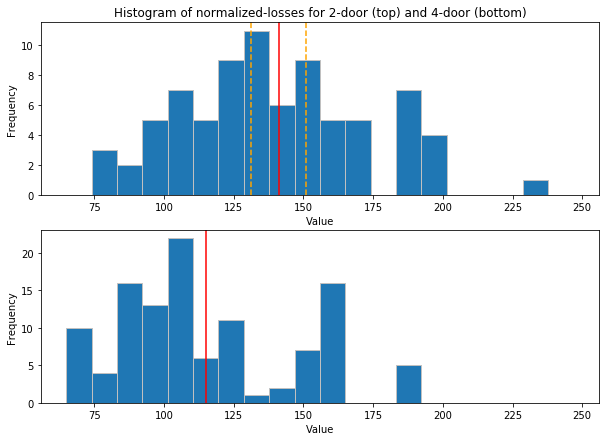

In [58]:
# perform a t-test to see if the means of the populations 
# can be considered the same
test = t_test(df1,df2)

# and plot
plot_t(df1,df2,test,cols=['2-door (top)','4-door (bottom)'],feature_name='normalized-losses')

In [59]:
print("Testing impact of num-of-doors feature on normalized-losses")
test

Testing impact of num-of-doors feature on normalized-losses


DegFreedom    1.638678e+02
Difference    2.595320e+01
Statistic     5.303077e+00
PValue        3.130329e-07
Low95CI       1.619071e+01
High95CI      3.571568e+01
dtype: float64

#### Result: num-of-doors DOES have an effect on normalized-losses
It turns out that the number of doors DOES affect the amount of normalized losses. 4-door cars have a lower normalized-losses than 2-door cars. Perhaps this is due to the relatively higher premium paid by owners of 4-door cars.  We proved this by doing a t-test under the null hypothesis that num-of-doors has no effect on normalized-losses. The p-value turned out to be vanishingly small, so we conclude that the difference in means (26.0) IS statistically signficant.

## Tukey HSD
Now let's move to a feature that has 3+ categorical values, and see whether these have any significance. Since we would otherwise need to run multiple t-test (and risk coming up with the "green M&M's taste better" problem), let's leverage Tukey's Honest Significant Differences method to test multiple categories at once.

### Testing: engine-type on log(highway-mpg)
I predict that engine-type will have a significance on log(highway-mpg). Let's test this out. Use only engine-type that have more than 10 observations.

In [60]:
df['engine-type'].value_counts()[ df['engine-type'].value_counts()>10 ]

ohc     140
ohcf     15
ohcv     12
l        12
Name: engine-type, dtype: int64

In [61]:
df1=df[df['engine-type']=='ohc']['highway-mpg']
df2=df[df['engine-type']=='ohcf']['highway-mpg']
df3=df[df['engine-type']=='ohcv']['highway-mpg']
df4=df[df['engine-type']=='dohc']['highway-mpg']
df5=df[df['engine-type']=='l']['highway-mpg']

# convert to log()
df1=np.log(df1)
df2=np.log(df2)
df3=np.log(df3)
df4=np.log(df4)
df5=np.log(df5)

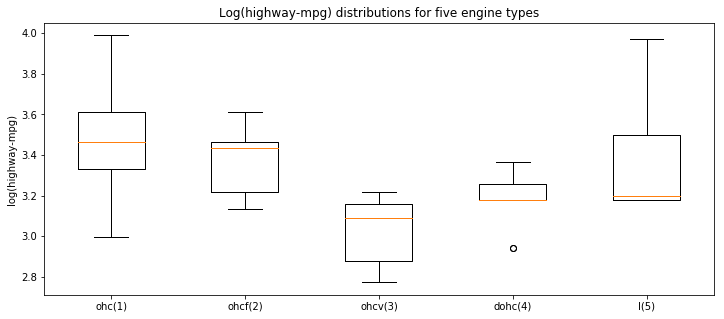

In [62]:
# let's do a box plot to show the relative distributions
# of the five categories

ax=plt.figure(figsize=(12,5)).gca()
plt.boxplot([df1, df2, df3, df4, df5])
plt.ylabel('log(highway-mpg)')
#plt.xlabel('Body style')
plt.title('Log(highway-mpg) distributions for five engine types')
ax.set_xticklabels(['ohc(1)','ohcf(2)','ohcv(3)','dohc(4)','l(5)'])
_=""

It's looking like there may be some limited relationships between engine type and highway-mpg. Note the 3rd category, ohcv, trends lower than the others. Let's run a formal ANOVA/Tukey to see if this is true.

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2    -0.0888  -0.2313  0.0536 False 
  1      3    -0.4444  -0.6022 -0.2867  True 
  1      4    -0.2816  -0.4533  -0.11   True 
  1      5    -0.1363  -0.2941  0.0214 False 
  2      3    -0.3556  -0.5587 -0.1525  True 
  2      4    -0.1928  -0.4069  0.0213 False 
  2      5    -0.0475  -0.2506  0.1556 False 
  3      4     0.1628  -0.0617  0.3873 False 
  3      5     0.3081   0.094   0.5222  True 
  4      5     0.1453  -0.0792  0.3698 False 
---------------------------------------------


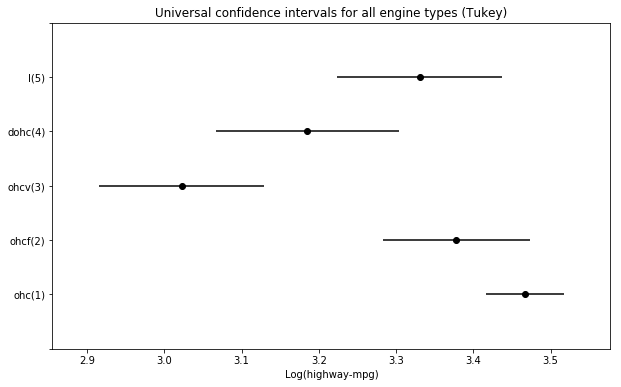

In [63]:
# run Tukey's ANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
df_anova = pd.DataFrame({'vals': df1.tolist() + df2.tolist() + df3.tolist() + df4.tolist() + df5.tolist(),
                   'group_num': ['1'] * len(df1) 
                         + ['2'] * len(df2)
                        + ['3'] * len(df3)
                        + ['4'] * len(df4)
                        + ['5'] * len(df5)})
Tukey_HSD = pairwise_tukeyhsd(df_anova.vals, df_anova.group_num)
print(Tukey_HSD)

# plot the results of the Tukey ANOVA test
ax=plt.figure().gca()
Tukey_HSD.plot_simultaneous(ax=ax)
ax.set_yticklabels(['','ohc(1)','ohcf(2)','ohcv(3)','dohc(4)','l(5)'])
ax.set_title("Universal confidence intervals for all engine types (Tukey)")
ax.set_xlabel("Log(highway-mpg)")
_=""

#### Result: Engine-type DOES have an effect on highway-mpg for some types
Both the graphical and the Tukey ANOVA calculations show that engine type does have a significant effect on highway-mpg:

* Cars with ohcv differ from all types other than dohc
* Cars with ohc differ from dohc and ohcv

The biggest effect on highway-mpg is for cars with **ohc, ohcf, and l** (best mileage), vs. cars with **ohcv** (poorer mileage).

## Bootstrap
Let's turn now to bootstrap to see whether we can detect differences in populations using this method.

### Testing: num-of-cylinders on normalized-losses
I wonder whether num-of-cylinders will have any significance on normalized-losses. Let's test this out. We have 4- and 6-cylinder cars.

In [64]:
df['num-of-cylinders'].value_counts()[ df['num-of-cylinders'].value_counts()>10 ]

four    150
six      23
Name: num-of-cylinders, dtype: int64

In [65]:
df1=df[df['num-of-cylinders']=='four']['normalized-losses']
df2=df[df['num-of-cylinders']=='six']['normalized-losses']

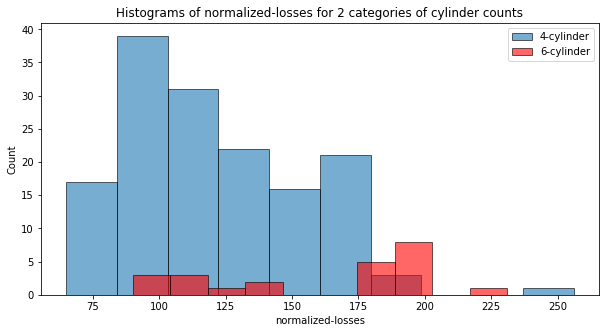

In [66]:
# let's do simple overlain histograms to see if the distributions
# are similar

ax=plt.figure(figsize=(10,5)).gca()
plt.hist(df1,color='C0',edgecolor='black',alpha=0.6,label="4-cylinder")
plt.hist(df2,color='red',edgecolor='black',alpha=0.6,label="6-cylinder")
ax.set_title("Histograms of normalized-losses for 2 categories of cylinder counts")
ax.set_xlabel("normalized-losses")
ax.set_ylabel("Count")
ax.legend()
_=""

From a visual perspective, it's looking doubtful that there's any difference in these populations. But, let's check it out using bootstrap. We'll try a bootstrap on the differences in means.

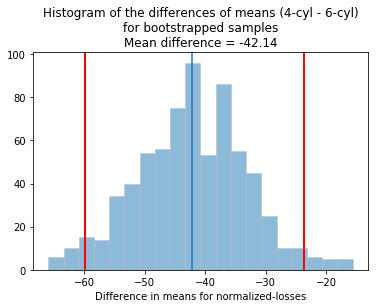

In [67]:
# copy libraries from notebook:
def plot_hist_bsmeans(x, bins, p=5, title="", xaxis=""):
    # Plot the distribution and mark the mean
    plt.hist(x, alpha=.5, bins=bins,edgecolor='silver')
    plt.axvline(x.mean())
    # central 100*(1-p)% of data   
    plt.axvline(np.percentile(x, p/2.), color='red', linewidth=2)
    plt.axvline(np.percentile(x, 100-p/2.), color='red', linewidth=2)
    plt.title(title+"\nMean difference = " + str(float('%.4g' % x.mean())))
    plt.xlabel(xaxis)

diffs = []
n_replicas = 700
for i in range(n_replicas):
    sample = df.sample(frac=1, replace=True)
    a_sample_mean = sample[sample['num-of-cylinders'] == 'four']['normalized-losses'].mean()
    b_sample_mean = sample[sample['num-of-cylinders'] == 'six']['normalized-losses'].mean()
    diffs.append(a_sample_mean - b_sample_mean)
diffs = pd.Series(diffs)

plot_hist_bsmeans(diffs,bins=20,
                  title="Histogram of the differences of means (4-cyl - 6-cyl)\nfor bootstrapped samples",
                  xaxis="Difference in means for normalized-losses")


#### Result: num-of-cylinders DOES have an effect on normalized-losses
As the graph above reveals, the differences in means for the bootstrapped samples lies far from zero. Even the confidence interval doesn't include zero. Therefore, there IS a statistical significance of num-of-cylinders on normalized-losses. We can conclude that 6-cylinder cars have larger normalized-losses than 4-cylinder cars by about 42 units. Interesting!

### Testing: num-of-cylinders on price
Let's try another bootstrap. Let's test whether num-of-cylinders will have any significance on log(price).

In [68]:
df['num-of-cylinders'].value_counts()[ df['num-of-cylinders'].value_counts()>10 ]

four    150
six      23
Name: num-of-cylinders, dtype: int64

In [69]:
df1=df[df['num-of-cylinders']=='four']['price']
df2=df[df['num-of-cylinders']=='six']['price']

# we want logs
df1=np.log(df1)
df2=np.log(df2)

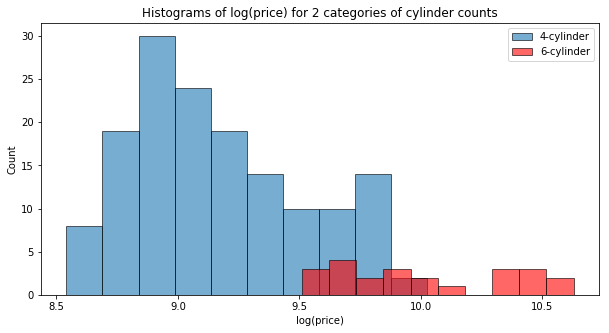

In [70]:
# let's do simple overlain histograms to see if the distributions
# are similar

ax=plt.figure(figsize=(10,5)).gca()
plt.hist(df1,color='C0',edgecolor='black',alpha=0.6,label="4-cylinder")
plt.hist(df2,color='red',edgecolor='black',alpha=0.6,label="6-cylinder")
ax.set_title("Histograms of log(price) for 2 categories of cylinder counts")
ax.set_xlabel("log(price)")
ax.set_ylabel("Count")
ax.legend()
_=""

From a visual perspective, it's looking highly likely that there's a difference in these populations. Let's check it out using bootstrap. We'll try a bootstrap on the differences in means.

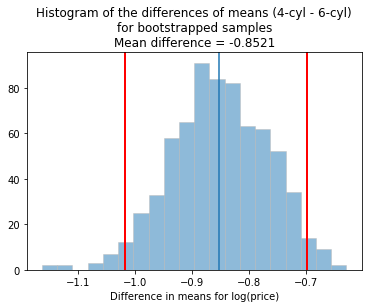

In [71]:
diffs = []
n_replicas = 700
for i in range(n_replicas):
    sample = df.sample(frac=1, replace=True)
    a_sample_mean = np.log(sample[sample['num-of-cylinders'] == 'four']['price']).mean()
    b_sample_mean = np.log(sample[sample['num-of-cylinders'] == 'six']['price']).mean()
    diffs.append(a_sample_mean - b_sample_mean)
diffs = pd.Series(diffs)

plot_hist_bsmeans(diffs,bins=20,
                  title="Histogram of the differences of means (4-cyl - 6-cyl)\nfor bootstrapped samples",
                  xaxis="Difference in means for log(price)")

#### Result: num-of-cylinders DOES have an effect on price
As the graph above reveals, the differences in means for the bootstrapped samples lies far from zero. The confidence interval doesn't include zero. Therefore, there IS a statistical significance of num-of-cylinders on log(price). We can conclude that the ratio of average prices for 4-cylinder cars to to 6-cylinder cars is about 0.85, and this is statistically significant. This isn't surprising.

## Bayes
Finally, let's bring Bayes into the picture by using Bayesian techniques to estimate whether populations have different summary statistics. This actually should be straightforward. We simply use Bayes techniques to compute the posteriors and credible intervals for two populations, and compare those intervals to see if there's any overlap. 

The complication is that we need to simulate an interesting experiment, so we'll do as before and start with a small subset of our full dataset as our "data." Then we'll apply priors to likelihoods based upon summary statistics from our full dataset, and observe how the results drift towards the full data.

We already did much of this before (see above), so we'll just leverage those libraries again. But, we'll use a different set of features for fun.

### Testing: fuel-system on normalized-losses
I wonder whether fuel-system will have any significance on normalized-losses. Let's test this out. We have the following fuel-systems that have more than 20 observations:

In [72]:
df['fuel-system'].value_counts()[ df['fuel-system'].value_counts()>20 ]

mpfi    86
2bbl    63
Name: fuel-system, dtype: int64

In [73]:
df1=df[df['fuel-system']=='mpfi']['normalized-losses']
df2=df[df['fuel-system']=='2bbl']['normalized-losses']

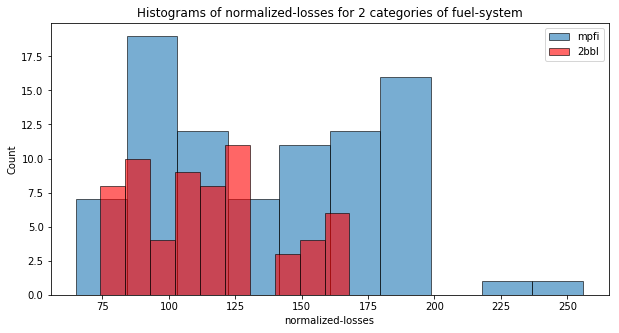

In [74]:
# let's do simple overlain histograms to see if the distributions
# are similar

ax=plt.figure(figsize=(10,5)).gca()
plt.hist(df1,color='C0',edgecolor='black',alpha=0.6,label="mpfi")
plt.hist(df2,color='red',edgecolor='black',alpha=0.6,label="2bbl")
ax.set_title("Histograms of normalized-losses for 2 categories of fuel-system")
ax.set_xlabel("normalized-losses")
ax.set_ylabel("Count")
ax.legend()
_=""

It seems plausible that fuel-system influences the normalized-losses. Let's continue with Bayes analysis to see.

In [75]:
# accumulate the mean and credible intervals for plotting/comparing both fuel-systems
stats_bayes = []
np.random.seed(121011) # fix the random state, so my conclusions apply under every run

#### Look at mpfi first

Data mean = 142.800, Data standard deviation = 40.990


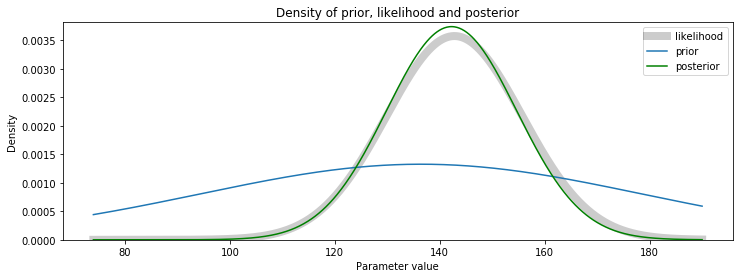

In [76]:
# grab a subset of our full mpfi data. the smaller the subset, the more interesting
# this will be.
n_subset = 10 # how big should our subset be? the original dataset has 86 mpfi records
fulldata = df[df['fuel-system']=='mpfi']
subset = fulldata.sample(n=n_subset,replace=False)
data = subset['normalized-losses']

# get a few values from the full dataset for this feature:
canonical_mean = fulldata['normalized-losses'].mean() # these will be used 
canonical_std = fulldata['normalized-losses'].std()   #  in the likelihood function

# we want to estimate the mean. the mean is our "parameter."
# range of the subset over which we'll estimate our parameter's probability
p = np.linspace(data.min(),data.max(),num=1000)

# create a prior. the parameters (mean, std) are based on the full dataset.
# our prior is normal in shape, centered at the full dataset's mean and with
# its variance.
pp = scipy.stats.norm.pdf(p, loc=canonical_mean, scale=canonical_std)
pp = pp / pp.sum() # normalize

# compute likelihood and posterior
likelihood = compute_like(p, data)
post = compute_posterior(pp, likelihood)

# and plot everything
plot_post(pp, likelihood, post, p)

In [77]:
# pick out the mode of the mean as predicted by the posterior, for interest sake
mode = pd.DataFrame({'x':p, 'y':post}).sort_values(by='y',ascending=False).iloc[0][0]
print("Mode of parameter according to posterior = ",mode)
print("Initial subset data mean = ",data.mean())
print("Nudge provided by prior = {}%".format(100*np.abs((mode-data.mean())/data.mean())))

Mode of parameter according to posterior =  142.276276276
Initial subset data mean =  142.8
Nudge provided by prior = 0.36675330792977556%


In [78]:
# values:
print("Bayes statistics for normalized-losses:")
print("Mean:", mode)

Bayes statistics for normalized-losses:
Mean: 142.276276276


Compute the credible interval, the Bayesian analog to confidence interval

The 0.950 credible interval is 117.892 to 166.545


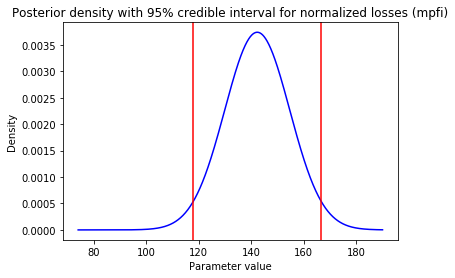

In [79]:
# compute the credible interval
lower_q, upper_q = [.025, .975]
lo,hi = calc_ci(p, post, lower_q, upper_q)
_=plt.title("Posterior density with 95% credible interval for normalized losses (mpfi)")

In [80]:
# and tuck these values away for later plotting
stats_bayes.append((mode,1,lo,hi,"mpfi"))
p0=p
post0=post
lo0=lo
hi0=hi

#### Now check out 2bbl

Data mean = 114.100, Data standard deviation = 17.824


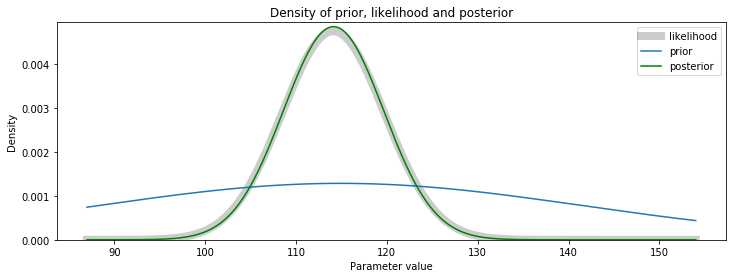

In [81]:
# grab a subset of our full 2bbl data. the smaller the subset, the more interesting
# this will be.
#n_subset = 20 # how big should our subset be? the original dataset has 63 2bbl records
fulldata = df[df['fuel-system']=='2bbl']
subset = fulldata.sample(n=n_subset,replace=False)
data = subset['normalized-losses']

# get a few values from the full dataset for this feature:
canonical_mean = fulldata['normalized-losses'].mean() # these will be used 
canonical_std = fulldata['normalized-losses'].std()   #  in the likelihood function

# we want to estimate the mean. the mean is our "parameter."
# range of the subset over which we'll estimate our parameter's probability
p = np.linspace(data.min(),data.max(),num=1000)

# create a prior. the parameters (mean, std) are based on the full dataset.
# our prior is normal in shape, centered at the full dataset's mean and with
# its variance.
pp = scipy.stats.norm.pdf(p, loc=canonical_mean, scale=canonical_std)
pp = pp / pp.sum() # normalize

# compute likelihood and posterior
likelihood = compute_like(p, data)
post = compute_posterior(pp, likelihood)

# and plot everything
plot_post(pp, likelihood, post, p)

In [82]:
# pick out the mode of the mean as predicted by the posterior, for interest sake
mode = pd.DataFrame({'x':p, 'y':post}).sort_values(by='y',ascending=False).iloc[0][0]
print("Mode of parameter according to posterior = ",mode)
print("Initial subset data mean = ",data.mean())
print("Nudge provided by prior = {}%".format(100*np.abs((mode-data.mean())/data.mean())))

Mode of parameter according to posterior =  114.162162162
Initial subset data mean =  114.1
Nudge provided by prior = 0.0544804225785864%


In [83]:
# values:
print("Bayes statistics for normalized-losses:")
print("Mean:", mode)

Bayes statistics for normalized-losses:
Mean: 114.162162162


Compute the credible interval, the Bayesian analog to confidence interval

The 0.950 credible interval is 103.364 to 124.960


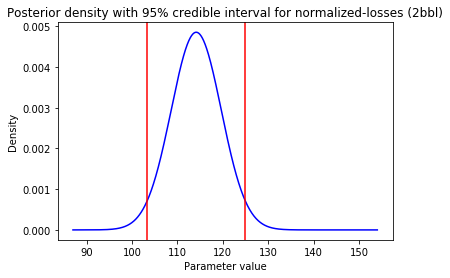

In [84]:
# compute the credible interval
lower_q, upper_q = [.025, .975]
lo,hi = calc_ci(p, post, lower_q, upper_q)
_=plt.title("Posterior density with 95% credible interval for normalized-losses (2bbl)")

In [85]:
# and tuck these values away for plotting, next.
stats_bayes.append((mode,2,lo,hi,"2bbl"))
p1=p
post1=post
lo1=lo
hi1=hi

**Compare the credible intervals of the two populations**

(74.0, 190.0)

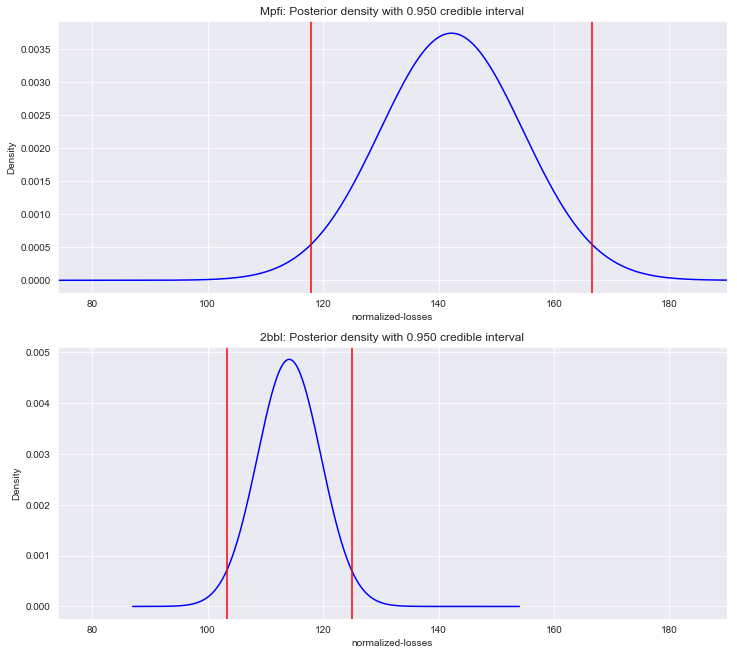

In [86]:
interval = upper_q - lower_q

xmin = min(min(p0),min(p1))
xmax = max(max(p0),max(p1))

plt.figure(figsize=(12,11))
sns.set_style('darkgrid')

# plot 0 (mpfi)
plt.subplot(2,1,1)
plt.title('Mpfi: Posterior density with %.3f credible interval' % interval)
plt.plot(p0, post0, color='blue')
plt.xlabel('normalized-losses')
plt.ylabel('Density')
plt.axvline(x=lo0, color='red')
plt.axvline(x=hi0, color='red')
plt.xlim(xmin,xmax)

# plot 1 (2bbl)
plt.subplot(2,1,2)
plt.title('2bbl: Posterior density with %.3f credible interval' % interval)
plt.plot(p1, post1, color='blue')
plt.xlabel('normalized-losses')
plt.ylabel('Density')
plt.axvline(x=lo1, color='red')
plt.axvline(x=hi1, color='red')
plt.xlim(xmin,xmax)

#### Result: There is NOT a statistically significant difference between normalized-losses under mpfi and 2bbl fuel types
While it was VERY CLOSE, the results of the Bayesian experiment show that the distribution of normalized-losses under the two fuel-types cannot be distinguished at the 95% confidence level. The credible intervals for the two cases overlap just enough to disallow that conclusion.


### Section summary
In this section we performed a Bayesian approach on two populations of normalized-losses defined by different fuel-systems. We found that fuel-system does not affect normalized-losses at the 95% confidence level. The more interesting part of the analysis is probably the Bayesian experiment we ran by taking a subset of the full data, and using a prior to "nudge" the summary statistics of the subset back towards the full set. In this simple experiment, we obtained up to 0.4% "improvement" of the mean in this fashion. Adding more data back into the experiment iteratively should bump the experimental mean towards the full data mean even more robustly.